# Settings

## Libraries

In [45]:
library(quantmod)
library(forecast)
library(rugarch)


#library(lattice)
#library(timeSeries)


In [46]:
source("~/works/utils/r/myutils.r")
source("~/works/utils/r/myarimagarch.r")

## Data

In [8]:
train_start <- "1991-01-01"
train_end <- '2019-12-31'
test_start <- '2020-01-01'
test_end <- '2020-12-31'

In [9]:
from <- train_start
to <- test_end
getSymbols("^GSPC", from=from, to=to)

In [19]:
spx = Cl(GSPC)
# daily log. return
spx.ret <- diff(log(spx))

In [20]:
train <- window(spx.ret, end=as.Date(train_end))
test <- window(spx.ret, start=as.Date(test_start), end=as.Date(test_end))

## CV Settings

In [25]:
YEAR <- 252
hori <- YEAR
peri <- floor(hori/2)
wind <- 5*YEAR

# Propeht

# ARIMA

In [23]:
cv.forecast <- function(x, h) {
    forecast(auto.arima(x, trace=TRUE, ic='aicc', seasonal=FALSE, 
                        #allowdrift=TRUE, allowmean = TRUE, # default
                        lambda="auto"), h=h)
}

In [41]:
result.m01 <- my.tsCV(train, cv.forecast, h=hori, window=wind, step=peri)


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : -9108.593
 ARIMA(0,0,0) with non-zero mean : -9107.734
 ARIMA(1,0,0) with non-zero mean : -9109.959
 ARIMA(0,0,1) with non-zero mean : -9105.941
 ARIMA(0,0,0) with zero mean     : 3573.686
 ARIMA(2,0,0) with non-zero mean : -9107.647
 ARIMA(1,0,1) with non-zero mean : -9111.705
 ARIMA(2,0,1) with non-zero mean : Inf
 ARIMA(1,0,2) with non-zero mean : Inf
 ARIMA(0,0,2) with non-zero mean : -9104.461
 ARIMA(1,0,1) with zero mean     : Inf

 Now re-fitting the best model(s) without approximations...

 ARIMA(1,0,1) with non-zero mean : Inf
 ARIMA(1,0,0) with non-zero mean : -9105.95

 Best model: ARIMA(1,0,0) with non-zero mean 


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : -9242.783
 ARIMA(0,0,0) with non-zero mean : -9241.675
 ARIMA(1,0,0) with non-zero mean : -9240.107
 ARIMA(0,0,1) with non-zero mean : -9240.993
 ARIMA(0,0,0) with zero mean 

In [62]:
from <- na.omit(result.m01[,1])[1]
from <- index(train[from])
print(paste('cv starts from', from, sep=' '))

[1] "cv starts from 1995-12-26"


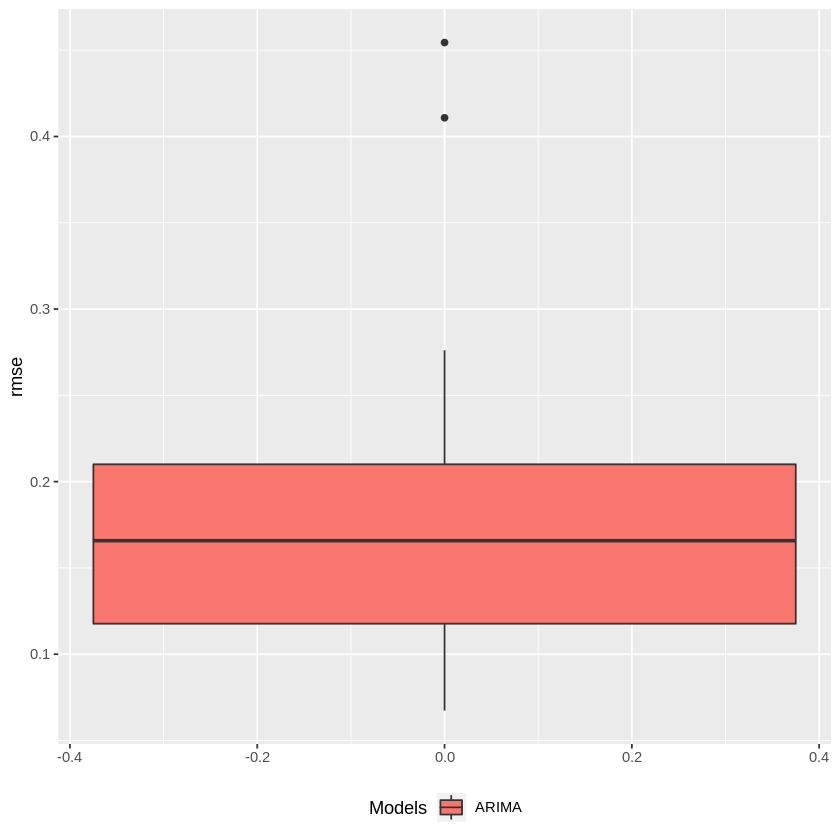

In [47]:
errors.m01 <- my.get_result(result.m01, 'ARIMA')
my.plot_errors(errors.m01, metrics=c('rmse'))

# Regression with ARIMA errors

In [64]:
xreg.1 <- RSI(spx)/100

                rsi
1991-01-02       NA
1991-01-03       NA
1991-01-04       NA
1991-01-07       NA
1991-01-08       NA
1991-01-09       NA
1991-01-10       NA
1991-01-11       NA
1991-01-14       NA
1991-01-15       NA
1991-01-16       NA
1991-01-17       NA
1991-01-18       NA
1991-01-21       NA
1991-01-22 52.06206
1991-01-23 54.14257
1991-01-24 58.77683
1991-01-25 60.00549
1991-01-28 59.94582
1991-01-29 59.64246
1991-01-30 64.76617
1991-01-31 67.41955
1991-02-01 65.86306
1991-02-04 70.30167
1991-02-05 72.43243
1991-02-06 76.64157
1991-02-07 73.87669
1991-02-08 75.60696
1991-02-11 80.21072
1991-02-12 75.11609
1991-02-13 76.92030
1991-02-14 69.51827
1991-02-15 72.40213
1991-02-19 72.59254
1991-02-20 66.25313
1991-02-21 66.00481
1991-02-22 66.54491
1991-02-25 67.84742
1991-02-26 60.80133
1991-02-27 65.12275
1991-02-28 64.08871
1991-03-01 66.95616
1991-03-04 65.07975
1991-03-05 70.79367
1991-03-06 69.87727
1991-03-07 69.41976
1991-03-08 67.65842
1991-03-11 64.03158
1991-03-12 59.01547


In [66]:
?BBands

BBands {TTR},R Documentation
HLC,"Object that is coercible to xts or matrix and contains High-Low-Close prices. If only a univariate series is given, it will be used. See details."
n,Number of periods for moving average.
maType,A function or a string naming the function to be called.
sd,The number of standard deviations to use.
...,Other arguments to be passed to the maType function.


In [67]:
?MACD

MACD {TTR},R Documentation
x,"Object that is coercible to xts or matrix; usually price, but can be volume, etc."
nFast,Number of periods for fast moving average.
nSlow,Number of periods for slow moving average.
nSig,Number of periods for signal moving average.
maType,"Either: A function or a string naming the function to be called. A list with the first component like (1) above, and additional parameters specified as named components. See Examples."
percent,"logical; if TRUE, the percentage difference between the fast and slow moving averages is returned, otherwise the difference between the respective averages is returned."
...,Other arguments to be passed to the maType function in case (1) above.


In [ ]:
train2 <- merge(train, vol, join='left', fill=NA)
train2 <- merge(train2, nas.adj, join='left', fill=NA)
train2 <- merge(train2, gold.usdam, join='left', fill=NA)
train2 <- merge(train2, wti, join='left', fill=NA)

colnames(train2) <- c('snp.close','snp.vol','nasdaq','gold','wti')

In [ ]:
cv.forecast <- function(x, h, xreg=NULL, xreg.msize=NULL) {
    if (!is.null(xreg)) {
        
        if (is.null(xreg.msize)) {
            xreg.m <- xreg # calc mean for future with all the xreg
        } else {
            # calc mean for future with xreg of length xreg.mszie
            xreg.m <- tail(xreg, n=xreg.msize)
        }
        
        if (is.null(dim(xreg))) {
            xreg.h <- mean(xreg.m)
        } else {
            xreg.h <- colMeans(xreg.m)  
        }
        
        xreg.h <- data.frame(xreg.h)
        #colnames(xreg.h) <- colnames(NA)
        colnames(xreg.h) <- colnames(xreg)
        xreg.h <- t(xreg.h)
        xreg.h <- as.ts(xreg.h[rep(seq_len(nrow(xreg.h)), h), ])
        
    } else {
        xreg.h <- NULL
    }
    
    forecast(auto.arima(x, trace=TRUE, ic='aicc', seasonal=FALSE, 
                        xreg=xreg, lambda="auto"), h=h, xreg=xreg.h)
}

# Examples

### Prepare Regression Data

In [57]:
head(GSPC)

           GSPC.Open GSPC.High GSPC.Low GSPC.Close GSPC.Volume GSPC.Adjusted
1991-01-02    330.20    330.75   326.45     326.45   126280000        326.45
1991-01-03    326.46    326.53   321.90     321.91   141450000        321.91
1991-01-04    321.91    322.35   318.87     321.00   140820000        321.00
1991-01-07    320.97    320.97   315.44     315.44   130610000        315.44
1991-01-08    315.44    316.97   313.79     314.90   143390000        314.90
1991-01-09    314.90    320.73   310.93     311.49   191100000        311.49

In [58]:
vol <- GSPC$GSPC.Volume
#vol.train <- vol

In [59]:
#window(spx, start=c(as.Date(test_start)), end=c(as.Date(test_end)))

In [60]:
head(train)

           GSPC.Adjusted
1991-01-02        326.45
1991-01-03        321.91
1991-01-04        321.00
1991-01-07        315.44
1991-01-08        314.90
1991-01-09        311.49

In [61]:
#class(train[1,0]); class(train)

#index(train)

train2 <- merge(train, vol, join='left', fill=NA)
colnames(train2) <- c('snp.close','snp.vol')

colSums(is.na(train2))
head(train2)

snp.close   snp.vol 
        0         0

           snp.close   snp.vol
1991-01-02    326.45 126280000
1991-01-03    321.91 141450000
1991-01-04    321.00 140820000
1991-01-07    315.44 130610000
1991-01-08    314.90 143390000
1991-01-09    311.49 191100000

#### Normalization

In [62]:
train2n <- my.minmaxscale(train2)
head(train2n)

            snp.close    snp.vol
1991-01-02 -0.6642147 -0.3724518
1991-01-03 -0.6673153 -0.3697999
1991-01-04 -0.6679368 -0.3699101
1991-01-07 -0.6717339 -0.3716948
1991-01-08 -0.6721027 -0.3694608
1991-01-09 -0.6744315 -0.3611208

### Check Correlation

#### OLS

In [25]:
a <- train2n[,1]
b <- train2n[,2]

In [26]:
reg <- lm(a~b)
summary(reg)


Call:
lm(formula = a ~ b)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.56941 -0.27841 -0.02718  0.19457  1.44954 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.211e-16  4.425e-03    0.00        1    
b           8.061e-01  1.449e-02   55.63   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3782 on 7304 degrees of freedom
Multiple R-squared:  0.2976,	Adjusted R-squared:  0.2975 
F-statistic:  3095 on 1 and 7304 DF,  p-value: < 2.2e-16


#### Generalized Least Squares

run failed

In [48]:
reg.2 <- gls(a~b, correlation=corARMA(p=1,q=0), method='ML')
summary(reg.2)

ERROR: Error in `dimnames<-.xts`(`*tmp*`, value = dn): length of 'dimnames' [2] not equal to array extent


run forever

In [ ]:
reg.3 <- gls(a~b, correlation=corARMA(p=1,q=1), method='ML')
summary(reg.3)

### Define Forecast Function 
- to include regression data

In [63]:
cv.forecast <- function(x, h, xreg=NULL) {
    if (!is.null(xreg)) {
        xreg.h <- rep(mean(xreg),h)
        xreg.h <- data.frame(xreg.h)
        colnames(xreg.h) <- colnames(xreg)
        xreg.h <- ts(xreg.h)
    } else {
        xreg.h <- NULL
    }
    
    forecast(auto.arima(x, trace=TRUE, ic='aicc', seasonal=FALSE, 
                        xreg=xreg, lambda="auto"), h=h, xreg=xreg.h)
}

#### Testing the fucntion

In [18]:
x.train <- window(train2, end=c(as.Date('1995-12-31')))
x.test <- window(train2, start=c(as.Date('1996-01-01')), end=c(as.Date('1996-12-31')))
c.train <- x.train$snp.close
r <- x.train$snp.vol
c.test <- x.test$snp.close

fc1 <- cv.forecast(c.train, 252, NULL)
fc2 <- cv.forecast(c.train, 252, r)


 Fitting models using approximations to speed things up...

 ARIMA(2,1,2) with drift         : 9645.052
 ARIMA(0,1,0) with drift         : 9641.368
 ARIMA(1,1,0) with drift         : 9641.68
 ARIMA(0,1,1) with drift         : 9643.25
 ARIMA(0,1,0)                    : 9648.057
 ARIMA(1,1,1) with drift         : 9641.213
 ARIMA(2,1,1) with drift         : Inf
 ARIMA(1,1,2) with drift         : Inf
 ARIMA(0,1,2) with drift         : 9645.021
 ARIMA(2,1,0) with drift         : 9644.356
 ARIMA(1,1,1)                    : 9649.269

 Now re-fitting the best model(s) without approximations...

 ARIMA(1,1,1) with drift         : 9647.924

 Best model: ARIMA(1,1,1) with drift         


 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : 9634.695
 Regression with ARIMA(0,1,0) errors : Inf
 Regression with ARIMA(1,1,0) errors : 9631.441
 Regression with ARIMA(0,1,1) errors : 9633.136
 Regression with ARIMA(0,1,0) errors : 9637.89
 Regression with A

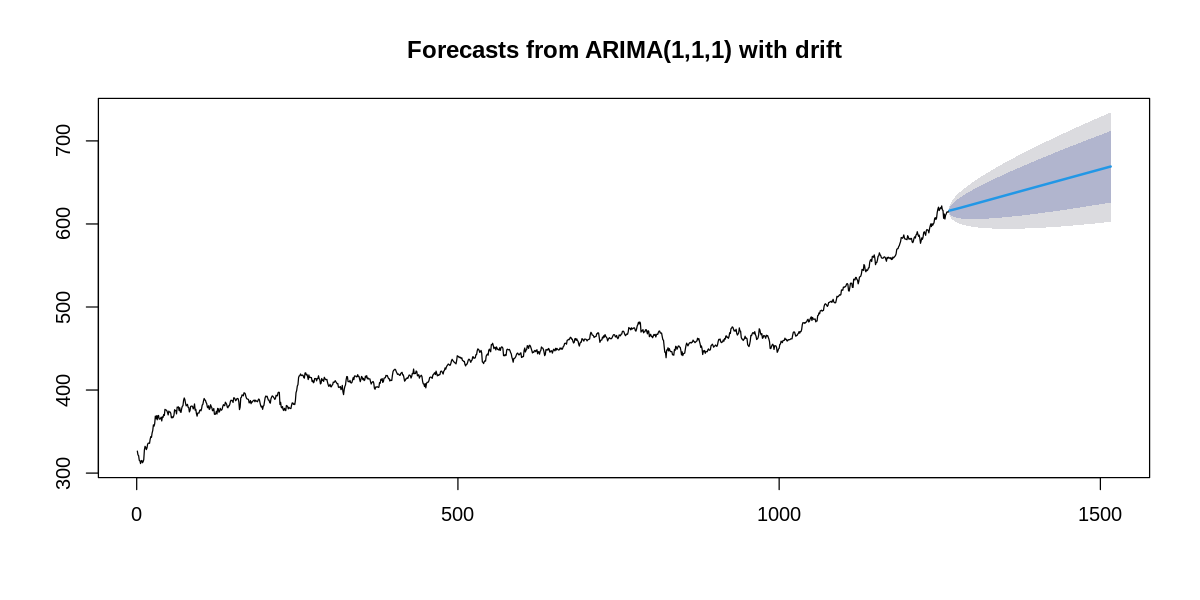

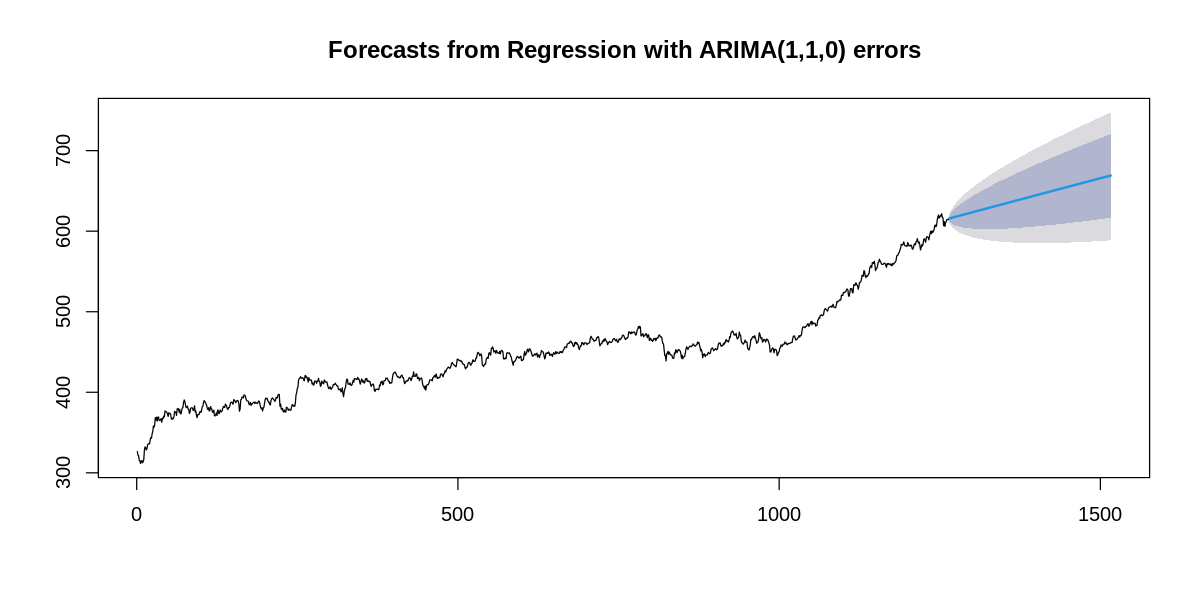

In [19]:
#par(mfrow=c(2,1))
plot(fc1)
plot(fc2)

### CV

In [64]:
results.m02 <- my.tsCV(train2n$snp.close, cv.forecast, h=hori, window=w, step=peri,
                      xreg=train2n$snp.vol)


 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : -13532.4
 Regression with ARIMA(0,1,0) errors : -13533.8
 Regression with ARIMA(1,1,0) errors : -13534.75
 Regression with ARIMA(0,1,1) errors : -13531.87
 Regression with ARIMA(0,1,0) errors : -13528.05
 Regression with ARIMA(2,1,0) errors : -13532.76
 Regression with ARIMA(1,1,1) errors : -13535.78
 Regression with ARIMA(2,1,1) errors : Inf
 Regression with ARIMA(1,1,2) errors : Inf
 Regression with ARIMA(0,1,2) errors : -13530.76
 Regression with ARIMA(1,1,1) errors : -13528.92

 Now re-fitting the best model(s) without approximations...

 Regression with ARIMA(1,1,1) errors : -13545.57

 Best model: Regression with ARIMA(1,1,1) errors 

[1] "2 % done."

 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : -13547.05
 Regression with ARIMA(0,1,0) errors : -13547.82
 Regression with ARIMA(1,1,0) errors : -13548.97
 Regression with ARIMA(0,1,

In [65]:
m2.r1 <- n.get_result(results.m02, 2)

In [36]:
results <- rbind(results, m2.r1)

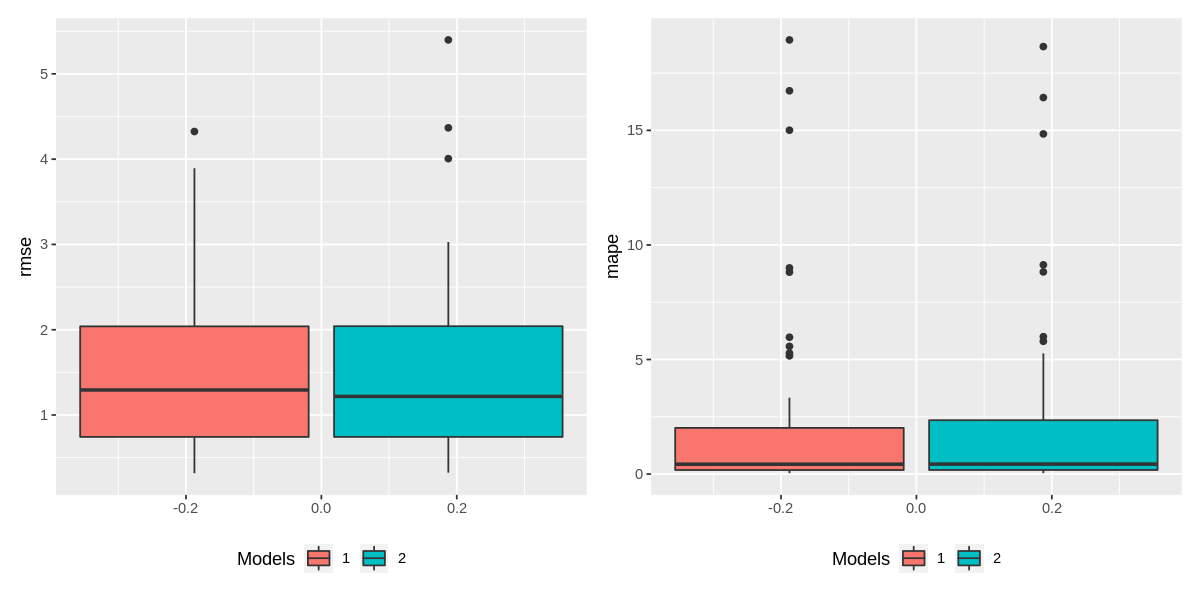

In [37]:
n.plot_errors(results)

## Model 3
- Regression with ARIMA errors in R
- multiple vars for regression

### Prepare Regression Data

S&P 500 Volume

In [83]:
vol <- GSPC$GSPC.Volume

#### Nasdaq Composite

In [84]:
n.symbol <- "^IXIC"
nas <- getSymbols(n.symbol, from=n.start, to=n.end, auto.assign = FALSE)
head(nas); tail(nas)

           IXIC.Open IXIC.High IXIC.Low IXIC.Close IXIC.Volume IXIC.Adjusted
1991-01-02     373.0     373.5    371.8      372.2    92020000         372.2
1991-01-03     371.2     371.8    367.4      367.5   108390000         367.5
1991-01-04     366.5     367.9    365.9      367.2   103830000         367.2
1991-01-07     363.5     365.8    360.1      360.2   109460000         360.2
1991-01-08     359.1     360.5    358.2      359.0   111730000         359.0
1991-01-09     362.4     365.0    357.1      357.5   145780000         357.5

           IXIC.Open IXIC.High IXIC.Low IXIC.Close IXIC.Volume IXIC.Adjusted
2020-12-22  12785.22  12840.57 12695.31   12807.92  5700760000      12807.92
2020-12-23  12834.94  12841.92 12758.67   12771.11  7028650000      12771.11
2020-12-24  12791.54  12833.55 12767.64   12804.73  3305950000      12804.73
2020-12-28  12914.64  12930.89 12827.45   12899.42  5076340000      12899.42
2020-12-29  12965.39  12973.33 12821.96   12850.22  4680780000      12850.22
2020-12-30  12906.51  12924.93 12857.76   12870.00  5292210000      12870.00

In [85]:
nas.adj <- nas$IXIC.Adjusted
sum(is.na(nas.adj))

[1] 0

#### Gold

In [86]:
library(Quandl)

n.symbol <- "LBMA/GOLD"
gold <- Quandl(n.symbol, start_date=n.start, end_date=n.end, order='asc', type='xts')
head(gold); tail(gold)

           USD (AM) USD (PM) GBP (AM) GBP (PM) EURO (AM) EURO (PM)
1991-01-02   392.50    390.8   202.48   200.93        NA        NA
1991-01-03   386.75    386.3   198.74   198.43        NA        NA
1991-01-04   388.10    387.4   199.35   199.85        NA        NA
1991-01-07   391.00    391.1   205.25   205.54        NA        NA
1991-01-08   392.80    389.7   206.19   204.55        NA        NA
1991-01-09   390.70    387.1   205.38   201.35        NA        NA

           USD (AM) USD (PM) GBP (AM) GBP (PM) EURO (AM) EURO (PM)
2020-12-22  1873.30   1877.1  1399.73  1405.95   1532.73   1538.10
2020-12-23  1867.10   1875.0  1390.06  1382.44   1532.14   1535.06
2020-12-24  1872.55       NA  1376.14       NA   1535.87        NA
2020-12-29  1873.90   1874.3  1388.93  1389.42   1529.66   1528.49
2020-12-30  1877.55   1887.6  1381.31  1387.39   1528.89   1535.19
2020-12-31  1891.10       NA  1382.58       NA   1539.92        NA

In [87]:
gold.usdam <- gold[,1]
sum(is.na(gold.usdam))

[1] 0

#### WTI

In [88]:
n.symbol <- "DCOILWTICO"
# from & end do not work with src "FRED"
wti <- getSymbols(n.symbol, auto.assign = FALSE, from=n.start, to=n.end, src = "FRED")
wti <- window(wti, start=n.start, end=n.end)
head(wti); tail(wti)

           DCOILWTICO
1991-01-01         NA
1991-01-02      26.53
1991-01-03      25.61
1991-01-04      24.88
1991-01-07      27.25
1991-01-08      27.50

           DCOILWTICO
2020-12-24      48.18
2020-12-25         NA
2020-12-28      47.50
2020-12-29      47.85
2020-12-30      48.24
2020-12-31      48.35

In [89]:
wti[wti<0]
window(wti, start='2020-04-15', end='2020-04-25')

           DCOILWTICO
2020-04-20     -36.98

           DCOILWTICO
2020-04-15      19.96
2020-04-16      19.82
2020-04-17      18.31
2020-04-20     -36.98
2020-04-21       8.91
2020-04-22      13.64
2020-04-23      15.06
2020-04-24      15.99

In [90]:
wti['2020-04-20'] <- 0
wti[wti<0]

     DCOILWTICO

In [91]:
train2 <- merge(train, vol, join='left', fill=NA)
colnames(train2) <- c('snp.close','snp.vol')

colSums(is.na(train2))
head(train2)

snp.close   snp.vol 
        0         0

           snp.close   snp.vol
1991-01-02    326.45 126280000
1991-01-03    321.91 141450000
1991-01-04    321.00 140820000
1991-01-07    315.44 130610000
1991-01-08    314.90 143390000
1991-01-09    311.49 191100000

#### Combine Data

In [92]:
train2 <- merge(train, vol, join='left', fill=NA)
train2 <- merge(train2, nas.adj, join='left', fill=NA)
train2 <- merge(train2, gold.usdam, join='left', fill=NA)
train2 <- merge(train2, wti, join='left', fill=NA)

colnames(train2) <- c('snp.close','snp.vol','nasdaq','gold','wti')

colSums(is.na(train2))
head(train2)

snp.close   snp.vol    nasdaq      gold       wti 
        0         0         0       130        28

           snp.close   snp.vol nasdaq   gold   wti
1991-01-02    326.45 126280000  372.2 392.50 26.53
1991-01-03    321.91 141450000  367.5 386.75 25.61
1991-01-04    321.00 140820000  367.2 388.10 24.88
1991-01-07    315.44 130610000  360.2 391.00 27.25
1991-01-08    314.90 143390000  359.0 392.80 27.50
1991-01-09    311.49 191100000  357.5 390.70 28.00

In [93]:
colSums(is.na(train2))

snp.close   snp.vol    nasdaq      gold       wti 
        0         0         0       130        28

In [94]:
tail(train2[is.na(train2$gold)])
tail(train2[is.na(train2$wti)])

           snp.close    snp.vol  nasdaq gold   wti
2018-08-27   2896.74 2854080000 8017.90   NA 69.97
2018-12-26   2467.70 4233990000 6554.36   NA 46.04
2019-04-22   2907.97 2997950000 8015.27   NA 65.66
2019-05-06   2932.47 3181520000 8123.29   NA 62.30
2019-08-26   2878.38 2857600000 7853.74   NA 53.54
2019-12-26   3239.91 2160680000 9022.39   NA 61.72

           snp.close    snp.vol  nasdaq    gold wti
2017-07-03   2429.01 1962290000 6110.06 1235.20  NA
2018-11-23   2632.56 1651650000 6938.98 1222.15  NA
2018-12-24   2351.10 2613930000 6192.92 1261.25  NA
2018-12-31   2506.85 3442870000 6635.28 1281.65  NA
2019-07-05   2990.41 2434210000 8161.79 1414.40  NA
2019-11-11   3087.01 3035530000 8464.28 1465.50  NA

In [95]:
window(train2, start='2019-12-20', end='2020-01-01')
window(train2, start='2019-11-03', end='2019-11-15')

           snp.close    snp.vol  nasdaq    gold   wti
2019-12-20   3221.22 6454270000 8924.96 1476.90 60.43
2019-12-23   3224.01 3060610000 8945.65 1483.95 60.51
2019-12-24   3223.38 1296540000 8952.88 1490.85 61.17
2019-12-26   3239.91 2160680000 9022.39      NA 61.72
2019-12-27   3240.02 2428670000 9006.62 1510.60 61.76
2019-12-30   3221.29 3013290000 8945.99 1511.50 61.66
2019-12-31   3230.78 2893810000 8972.60 1523.00 61.14

           snp.close    snp.vol  nasdaq    gold   wti
2019-11-04   3078.27 4146850000 8433.20 1509.20 56.33
2019-11-05   3074.62 4486130000 8434.68 1504.60 57.04
2019-11-06   3076.78 4458190000 8410.63 1488.55 56.15
2019-11-07   3085.18 4144640000 8434.52 1484.10 56.91
2019-11-08   3093.08 3499150000 8475.31 1466.85 57.02
2019-11-11   3087.01 3035530000 8464.28 1465.50    NA
2019-11-12   3091.84 3466010000 8486.09 1455.00 56.67
2019-11-13   3094.04 3509280000 8482.10 1463.45 56.88
2019-11-14   3096.63 3276070000 8479.02 1467.65 56.57
2019-11-15   3120.46 3335650000 8540.83 1465.60 57.54

In [96]:
train2 <- na.locf(train2)

In [97]:
window(train2, start='2019-12-20', end='2020-01-01')
window(train2, start='2019-11-03', end='2019-11-15')

           snp.close    snp.vol  nasdaq    gold   wti
2019-12-20   3221.22 6454270000 8924.96 1476.90 60.43
2019-12-23   3224.01 3060610000 8945.65 1483.95 60.51
2019-12-24   3223.38 1296540000 8952.88 1490.85 61.17
2019-12-26   3239.91 2160680000 9022.39 1490.85 61.72
2019-12-27   3240.02 2428670000 9006.62 1510.60 61.76
2019-12-30   3221.29 3013290000 8945.99 1511.50 61.66
2019-12-31   3230.78 2893810000 8972.60 1523.00 61.14

           snp.close    snp.vol  nasdaq    gold   wti
2019-11-04   3078.27 4146850000 8433.20 1509.20 56.33
2019-11-05   3074.62 4486130000 8434.68 1504.60 57.04
2019-11-06   3076.78 4458190000 8410.63 1488.55 56.15
2019-11-07   3085.18 4144640000 8434.52 1484.10 56.91
2019-11-08   3093.08 3499150000 8475.31 1466.85 57.02
2019-11-11   3087.01 3035530000 8464.28 1465.50 57.02
2019-11-12   3091.84 3466010000 8486.09 1455.00 56.67
2019-11-13   3094.04 3509280000 8482.10 1463.45 56.88
2019-11-14   3096.63 3276070000 8479.02 1467.65 56.57
2019-11-15   3120.46 3335650000 8540.83 1465.60 57.54

#### Normalization

In [98]:
train2n <- my.minmaxscale(train2)
head(train2n)

            snp.close    snp.vol     nasdaq       gold        wti
1991-01-02 -0.6642147 -0.3724518 -0.5503244 -0.4390499 -0.3275023
1991-01-03 -0.6673153 -0.3697999 -0.5514090 -0.4460702 -0.3411836
1991-01-04 -0.6679368 -0.3699101 -0.5514782 -0.4444220 -0.3520395
1991-01-07 -0.6717339 -0.3716948 -0.5530936 -0.4408813 -0.3167952
1991-01-08 -0.6721027 -0.3694608 -0.5533706 -0.4386836 -0.3130775
1991-01-09 -0.6744315 -0.3611208 -0.5537167 -0.4412476 -0.3056420

#### Check Correlation

In [99]:
c <- colnames(train2n)
a <- train2n[,1]

for (i in 2:5) {
    b <- train2n[,i]
    reg <- lm(a~b)
    s <- summary(reg)
    s1 <- s$sigma
    s2 <- s$adj.r.squared
    s3 <- pf(s$fstatistic[1],s$fstatistic[2],s$fstatistic[3], lower.tail=FALSE)
    sn <- sprintf("%-7s >> Res.SE: %.3f, Adj.R^2: %.3f, F-stat p-val: %.3e", c[i], s1, s2, s3)
    print(sn)
}

[1] "snp.vol >> Res.SE: 0.378, Adj.R^2: 0.298, F-stat p-val: 0.000e+00"
[1] "nasdaq  >> Res.SE: 0.086, Adj.R^2: 0.963, F-stat p-val: 0.000e+00"
[1] "gold    >> Res.SE: 0.338, Adj.R^2: 0.438, F-stat p-val: 0.000e+00"
[1] "wti     >> Res.SE: 0.403, Adj.R^2: 0.204, F-stat p-val: 0.000e+00"


### Define Forecast Function 
- include multiple regression data

In [106]:
cv.forecast <- function(x, h, xreg=NULL, xreg.msize=NULL) {
    if (!is.null(xreg)) {
        
        if (is.null(xreg.msize)) {
            xreg.m <- xreg # calc mean for future with all the xreg
        } else {
            # calc mean for future with xreg of length xreg.mszie
            xreg.m <- tail(xreg, n=xreg.msize)
        }
        
        if (is.null(dim(xreg))) {
            xreg.h <- mean(xreg.m)
        } else {
            xreg.h <- colMeans(xreg.m)  
        }
        
        xreg.h <- data.frame(xreg.h)
        #colnames(xreg.h) <- colnames(NA)
        colnames(xreg.h) <- colnames(xreg)
        xreg.h <- t(xreg.h)
        xreg.h <- as.ts(xreg.h[rep(seq_len(nrow(xreg.h)), h), ])
        
    } else {
        xreg.h <- NULL
    }
    
    print(head(xreg.h)) # testing
    
    forecast(auto.arima(x, trace=TRUE, ic='aicc', seasonal=FALSE, 
                        xreg=xreg, lambda="auto"), h=h, xreg=xreg.h)
}

##### Debugging

In [100]:
x.train <- window(train2, end=c(as.Date('1995-12-31')))
x.test <- window(train2, start=c(as.Date('1996-01-01')), end=c(as.Date('1996-12-31')))
c.train <- x.train$snp.close

#r <- x.train$snp.vol
r <- x.train[,2:4]

c.test <- x.test$snp.close

#fc1 <- cv.forecast(c.train, 252, r, NULL)

In [103]:


x <- x.train
h <- 252
xreg <- r
xreg.msize <- NULL

if (!is.null(xreg)) {

    if (is.null(xreg.msize)) {
        xreg.m <- xreg # calc mean for future with all the xreg
    } else {
        # calc mean for future with xreg of length xreg.mszie
        xreg.m <- tail(xreg, n=xreg.msize)
    }

    if (is.null(dim(xreg))) {
        xreg.h <- mean(xreg.m)
    } else {
        xreg.h <- colMeans(xreg.m)  
    }

    xreg.h <- data.frame(xreg.h)
    colnames(xreg.h) <- colnames(NA)
    #colnames(xreg.h) <- colnames(xreg)
    xreg.h <- t(xreg.h)
    xreg.h <- as.ts(xreg.h[rep(seq_len(nrow(xreg.h)), h), ])

} else {
    xreg.h <- NULL
}

head(xreg)
head(xreg.h)

             snp.vol nasdaq   gold
1991-01-02 126280000  372.2 392.50
1991-01-03 141450000  367.5 386.75
1991-01-04 140820000  367.2 388.10
1991-01-07 130610000  360.2 391.00
1991-01-08 143390000  359.0 392.80
1991-01-09 191100000  357.5 390.70

,snp.vol,nasdaq,gold
1,256580008,696.2869,366.8277
2,256580008,696.2869,366.8277
3,256580008,696.2869,366.8277
4,256580008,696.2869,366.8277
5,256580008,696.2869,366.8277
6,256580008,696.2869,366.8277


In [105]:
head(xreg.h[,1])

A Time Series:
[1] 256580008 256580008 256580008 256580008 256580008 256580008

#### Testing the function
- to check new cv.forecast works fine with single xreg

In [55]:
xreg <- train2n[,'snp.vol']
results.m03 <- my.tsCV(train2n[,1], cv.forecast, h=hori, window=w, step=peri,
                       xreg=xreg)
m3.r1 <- n.get_result(results.m03, 'testing')


 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : -13532.4
 Regression with ARIMA(0,1,0) errors : -13533.8
 Regression with ARIMA(1,1,0) errors : -13534.75
 Regression with ARIMA(0,1,1) errors : -13531.87
 Regression with ARIMA(0,1,0) errors : -13528.05
 Regression with ARIMA(2,1,0) errors : -13532.76
 Regression with ARIMA(1,1,1) errors : -13535.78
 Regression with ARIMA(2,1,1) errors : Inf
 Regression with ARIMA(1,1,2) errors : Inf
 Regression with ARIMA(0,1,2) errors : -13530.76
 Regression with ARIMA(1,1,1) errors : -13528.92

 Now re-fitting the best model(s) without approximations...

 Regression with ARIMA(1,1,1) errors : -13545.57

 Best model: Regression with ARIMA(1,1,1) errors 

[1] "2 % done."

 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : -13547.05
 Regression with ARIMA(0,1,0) errors : -13547.82
 Regression with ARIMA(1,1,0) errors : -13548.97
 Regression with ARIMA(0,1,

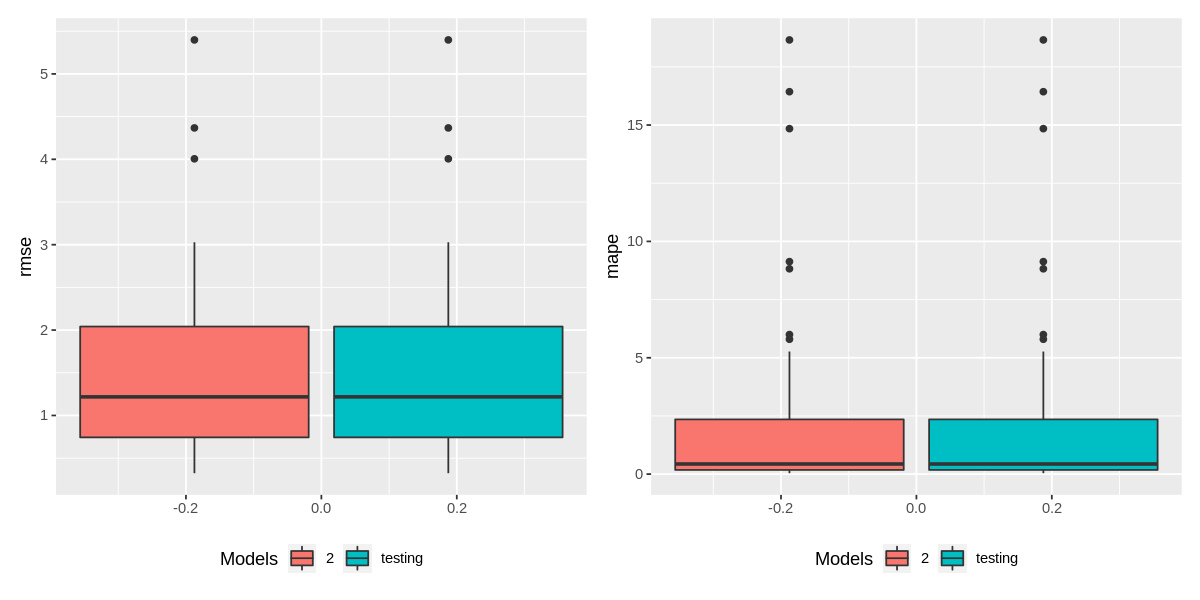

In [66]:
n.plot_errors(rbind(m2.r1, m3.r1))

#### Data length to calc mean of xreg for prediction

In [67]:
results.m03 <- my.tsCV(train2n[,1], cv.forecast, h=hori, window=w, step=peri,
                       xreg=xreg, xreg.mize=hori)
m3.r1s <- n.get_result(results.m03, 'testing2')


 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : -13532.4
 Regression with ARIMA(0,1,0) errors : -13533.8
 Regression with ARIMA(1,1,0) errors : -13534.75
 Regression with ARIMA(0,1,1) errors : -13531.87
 Regression with ARIMA(0,1,0) errors : -13528.05
 Regression with ARIMA(2,1,0) errors : -13532.76
 Regression with ARIMA(1,1,1) errors : -13535.78
 Regression with ARIMA(2,1,1) errors : Inf
 Regression with ARIMA(1,1,2) errors : Inf
 Regression with ARIMA(0,1,2) errors : -13530.76
 Regression with ARIMA(1,1,1) errors : -13528.92

 Now re-fitting the best model(s) without approximations...

 Regression with ARIMA(1,1,1) errors : -13545.57

 Best model: Regression with ARIMA(1,1,1) errors 

[1] "2 % done."

 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : -13547.05
 Regression with ARIMA(0,1,0) errors : -13547.82
 Regression with ARIMA(1,1,0) errors : -13548.97
 Regression with ARIMA(0,1,

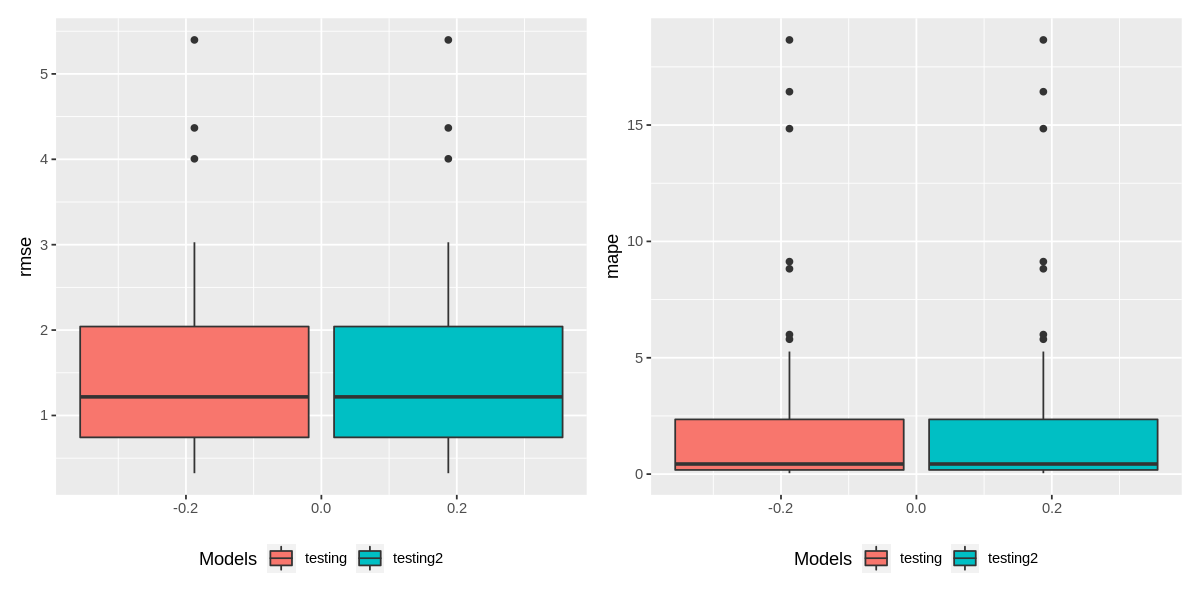

In [68]:
n.plot_errors(rbind(m3.r1, m3.r1s))

In [107]:
x.train <- window(train2, end=c(as.Date('1995-12-31')))
x.test <- window(train2, start=c(as.Date('1996-01-01')), end=c(as.Date('1996-12-31')))
c.train <- x.train$snp.close
r <- x.train$snp.vol
c.test <- x.test$snp.close

fc1 <- cv.forecast(c.train, 252, r, NULL)
fc2 <- cv.forecast(c.train, 252, r, 252)

Time Series:
Start = 1 
End = 6 
Frequency = 1 
[1] 256580008 256580008 256580008 256580008 256580008 256580008

 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : 9634.695
 Regression with ARIMA(0,1,0) errors : Inf
 Regression with ARIMA(1,1,0) errors : 9631.441
 Regression with ARIMA(0,1,1) errors : 9633.136
 Regression with ARIMA(0,1,0) errors : 9637.89
 Regression with ARIMA(2,1,0) errors : 9633.738
 Regression with ARIMA(1,1,1) errors : Inf
 Regression with ARIMA(2,1,1) errors : Inf
 Regression with ARIMA(1,1,0) errors : Inf

 Now re-fitting the best model(s) without approximations...

 Regression with ARIMA(1,1,0) errors : 9637.927

 Best model: Regression with ARIMA(1,1,0) errors 



Warning message in forecast.forecast_ARIMA(auto.arima(x, trace = TRUE, ic = "aicc", :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”


Time Series:
Start = 1 
End = 6 
Frequency = 1 
[1] 346203770 346203770 346203770 346203770 346203770 346203770

 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : 9634.695
 Regression with ARIMA(0,1,0) errors : Inf
 Regression with ARIMA(1,1,0) errors : 9631.441
 Regression with ARIMA(0,1,1) errors : 9633.136
 Regression with ARIMA(0,1,0) errors : 9637.89
 Regression with ARIMA(2,1,0) errors : 9633.738
 Regression with ARIMA(1,1,1) errors : Inf
 Regression with ARIMA(2,1,1) errors : Inf
 Regression with ARIMA(1,1,0) errors : Inf

 Now re-fitting the best model(s) without approximations...

 Regression with ARIMA(1,1,0) errors : 9637.927

 Best model: Regression with ARIMA(1,1,0) errors 



Warning message in forecast.forecast_ARIMA(auto.arima(x, trace = TRUE, ic = "aicc", :
“xreg contains different column names from the xreg used in training. Please check that the regressors are in the same order.”


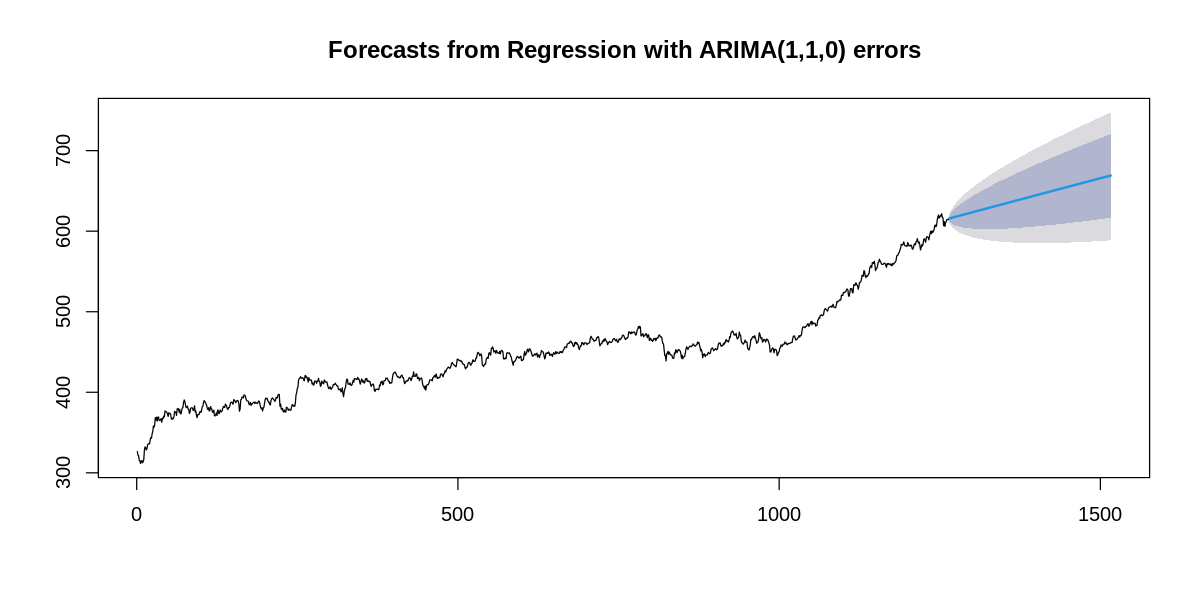

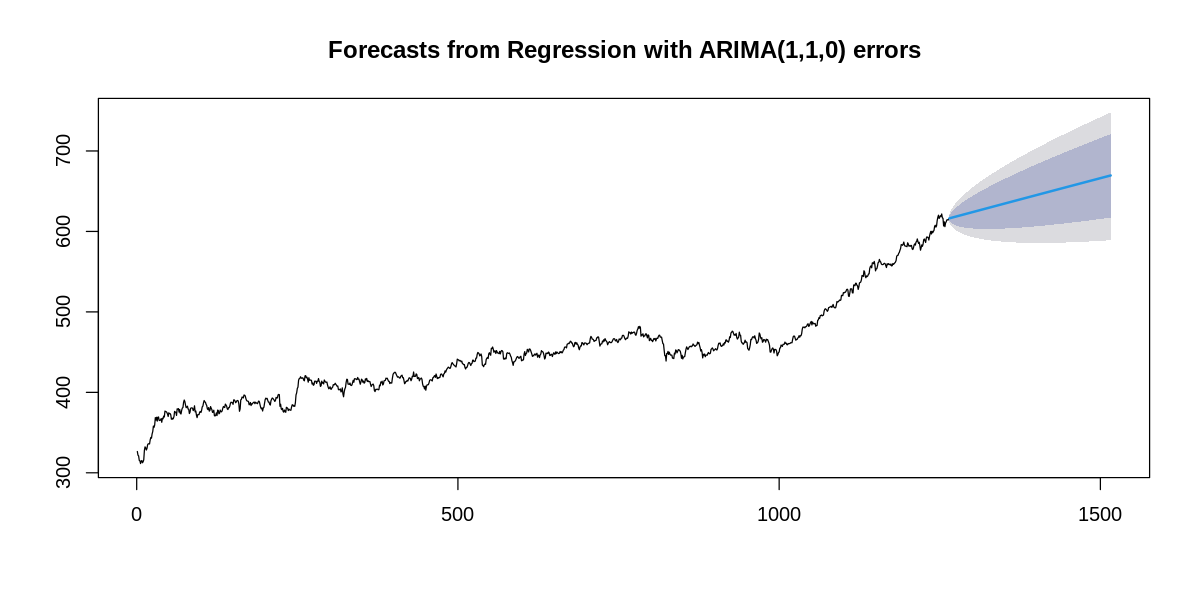

In [108]:
#par(mfrow=c(2,1))
plot(fc1)
plot(fc2)

### CV

In [60]:
#xreg <- train2n[,'snp.vol']
xreg <- train2n[,'nasdaq'] # best corr with s&p
#xreg <- train2n[,3:4]
head(xreg)

               nasdaq
1991-01-02 -0.5503244
1991-01-03 -0.5514090
1991-01-04 -0.5514782
1991-01-07 -0.5530936
1991-01-08 -0.5533706
1991-01-09 -0.5537167

In [61]:
results.m03 <- my.tsCV(train2n[,1], cv.forecast, h=hori, window=w, step=peri,
                       xreg=xreg)
m3.r2 <- n.get_result(results.m03, 'xreg:nasdaq')


 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : -14447.19
 Regression with ARIMA(0,1,0) errors : -14448.26
 Regression with ARIMA(1,1,0) errors : -14448.97
 Regression with ARIMA(0,1,1) errors : -14446.54
 Regression with ARIMA(0,1,0) errors : -14449.9
 Regression with ARIMA(1,1,1) errors : -14449.93
 Regression with ARIMA(2,1,1) errors : Inf
 Regression with ARIMA(1,1,2) errors : Inf
 Regression with ARIMA(0,1,2) errors : -14445.07
 Regression with ARIMA(2,1,0) errors : -14446.87
 Regression with ARIMA(1,1,1) errors : -14451.26
 Regression with ARIMA(0,1,1) errors : -14448.17
 Regression with ARIMA(1,1,0) errors : -14450.52
 Regression with ARIMA(2,1,1) errors : Inf
 Regression with ARIMA(1,1,2) errors : Inf
 Regression with ARIMA(0,1,2) errors : -14446.71
 Regression with ARIMA(2,1,0) errors : -14448.41
 Regression with ARIMA(2,1,2) errors : -14448.55

 Now re-fitting the best model(s) without approximations...

 Regression with ARI

In [62]:
xreg <- train2n[,3:4]
head(xreg)

               nasdaq       gold
1991-01-02 -0.5503244 -0.4390499
1991-01-03 -0.5514090 -0.4460702
1991-01-04 -0.5514782 -0.4444220
1991-01-07 -0.5530936 -0.4408813
1991-01-08 -0.5533706 -0.4386836
1991-01-09 -0.5537167 -0.4412476

In [63]:
results.m03 <- my.tsCV(train2n[,1], cv.forecast, h=hori, window=w, step=peri,
                       xreg=xreg)
m3.r3 <- n.get_result(results.m03, 'xreg:nasdaq & gold')


 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : -14446.72
 Regression with ARIMA(0,1,0) errors : -14447.01
 Regression with ARIMA(1,1,0) errors : -14448.21
 Regression with ARIMA(0,1,1) errors : -14445.49
 Regression with ARIMA(0,1,0) errors : -14448.65
 Regression with ARIMA(1,1,1) errors : -14449
 Regression with ARIMA(2,1,1) errors : Inf
 Regression with ARIMA(1,1,2) errors : Inf
 Regression with ARIMA(0,1,2) errors : -14444.08
 Regression with ARIMA(2,1,0) errors : -14446.2
 Regression with ARIMA(1,1,1) errors : Inf

 Now re-fitting the best model(s) without approximations...

 Regression with ARIMA(1,1,1) errors : Inf
 Regression with ARIMA(0,1,0) errors : -14462.98

 Best model: Regression with ARIMA(0,1,0) errors 

[1] "2 % done."

 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : -14468.25
 Regression with ARIMA(0,1,0) errors : -14461.76
 Regression with ARIMA(1,1,0) errors : -1

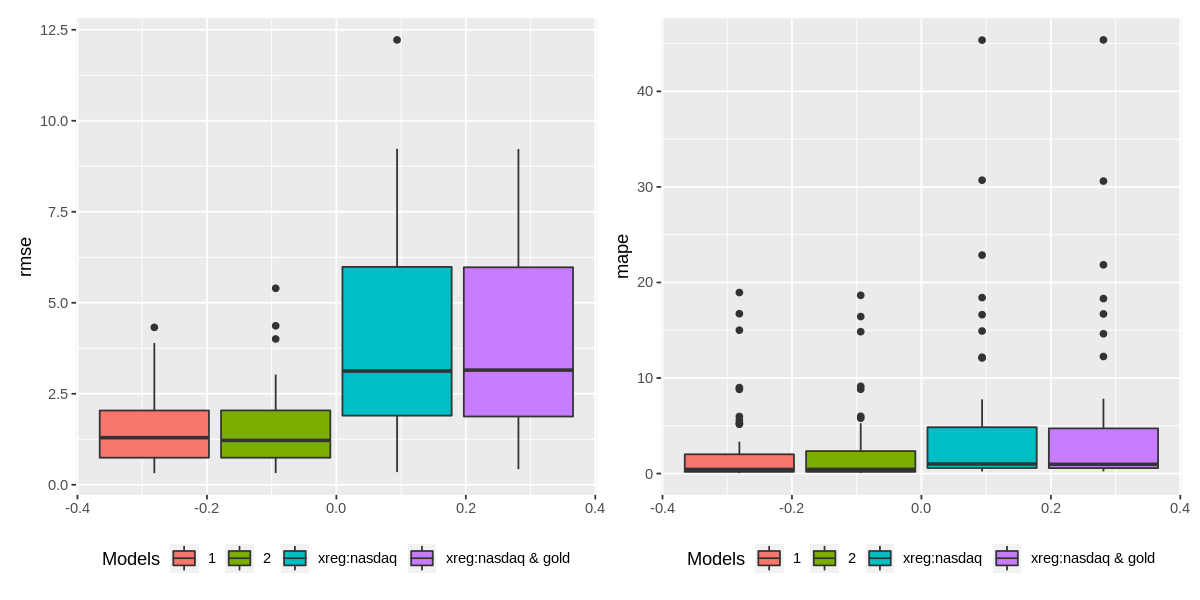

In [66]:
rn <- rbind(m1.r2, m2.r1)
rn <- rbind(rn, m3.r2)
rn <- rbind(rn, m3.r3)
n.plot_errors(rn)

In [68]:
xreg <- train2n[,2:5]
head(xreg)

              snp.vol     nasdaq       gold        wti
1991-01-02 -0.3724518 -0.5503244 -0.4390499 -0.3275023
1991-01-03 -0.3697999 -0.5514090 -0.4460702 -0.3411836
1991-01-04 -0.3699101 -0.5514782 -0.4444220 -0.3520395
1991-01-07 -0.3716948 -0.5530936 -0.4408813 -0.3167952
1991-01-08 -0.3694608 -0.5533706 -0.4386836 -0.3130775
1991-01-09 -0.3611208 -0.5537167 -0.4412476 -0.3056420

In [69]:
results.m03 <- my.tsCV(train2n[,1], cv.forecast, h=hori, window=w, step=peri,
                       xreg=xreg)
m3.r4 <- n.get_result(results.m03, 'xreg:all')


 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,0,2) errors : -14512.6
 Regression with ARIMA(0,0,0) errors : -10953.43
 Regression with ARIMA(1,0,0) errors : -14509.87
 Regression with ARIMA(0,0,1) errors : -12214.15
 Regression with ARIMA(0,0,0) errors : -8661.673
 Regression with ARIMA(1,0,2) errors : -14509.51
 Regression with ARIMA(2,0,1) errors : -14510.04
 Regression with ARIMA(3,0,2) errors : -14511.8
 Regression with ARIMA(2,0,3) errors : -14512.74
 Regression with ARIMA(1,0,3) errors : -14507.97
 Regression with ARIMA(3,0,3) errors : -14509.91
 Regression with ARIMA(2,0,4) errors : -14511.01
 Regression with ARIMA(1,0,4) errors : -14507.09
 Regression with ARIMA(3,0,4) errors : -14508.65
 Regression with ARIMA(2,0,3) errors : Inf

 Now re-fitting the best model(s) without approximations...

 Regression with ARIMA(2,0,3) errors : -14502.41

 Best model: Regression with ARIMA(2,0,3) errors 

[1] "2 % done."

 Fitting models using approximat

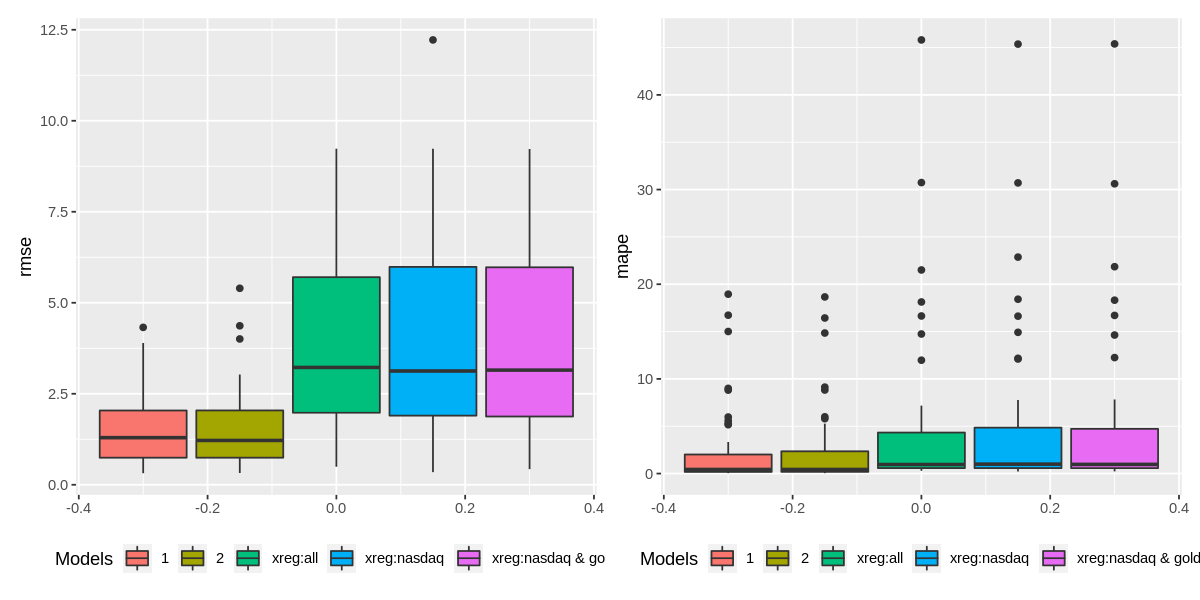

In [70]:
rn <- rbind(rn, m3.r4)
n.plot_errors(rn)

# ARIMA+GARCH

In [7]:
start <- "1991-01-01"
end <- "2020-12-31"

getSymbols("^GSPC", from=start, to=end)
spClose = Cl(GSPC)

[1] "^GSPC"

In [8]:
#train_end <- '1999-12-31'
#test_start <- '2000-01-01'
#test_end <- '2000-12-31'

train_end <- '2019-12-31'
test_start <- '2020-01-01'
test_end <- '2020-12-31'

In [9]:
hori <- 252
peri <- floor(hori/2)
w <- 252*5

lookahead <- 1

In [10]:
train <- window(spClose, end=as.Date(train_end))
test <- window(spClose, start=as.Date(test_start), end=as.Date(test_end))
#head(train); tail(train); head(test); tail(test)

In [11]:
train <- diff(log(train), lookahead)
train[as.character(head(index(train),lookahead))] <- 0

In [36]:
cv.forecast <- function(x, h) {
    forc <- ag2.forecast(x, h, out.sample=0)
    if (!is.na(forc)) {
        fc <- list(method = "ARIMA+GARCH Forecasting", mean=forc@forecast$seriesFor[,1])
        attr(fc$mean, "names") <- NULL
        return(fc)
    }
}

In [37]:
results <- my.tsCV(train, cv.forecast, h=hori, window=w, step=peri)

[1] "2 % done."
[1] "4 % done."
[1] "6 % done."
[1] "8 % done."
[1] "10 % done."
[1] "12 % done."
[1] "GARCH model does not converge"
[1] "15 % done."
[1] "17 % done."
[1] "19 % done."
[1] "21 % done."
[1] "23 % done."
[1] "25 % done."
[1] "27 % done."
[1] "29 % done."
[1] "31 % done."
[1] "33 % done."
[1] "35 % done."
[1] "38 % done."
[1] "40 % done."
[1] "42 % done."
[1] "44 % done."
[1] "46 % done."
[1] "48 % done."
[1] "50 % done."
[1] "52 % done."
[1] "54 % done."
[1] "56 % done."
[1] "58 % done."
[1] "60 % done."
[1] "GARCH model does not converge"
[1] "62 % done."
[1] "GARCH model does not converge"
[1] "65 % done."
[1] "67 % done."
[1] "69 % done."
[1] "71 % done."
[1] "73 % done."
[1] "75 % done."
[1] "77 % done."
[1] "79 % done."
[1] "81 % done."
[1] "83 % done."
[1] "85 % done."
[1] "88 % done."
[1] "90 % done."
[1] "92 % done."
[1] "94 % done."
[1] "96 % done."
[1] "98 % done."
[1] "100 % done."


In [40]:
if (sum(!is.na(results)) == 0) {
    print('no result available')
}

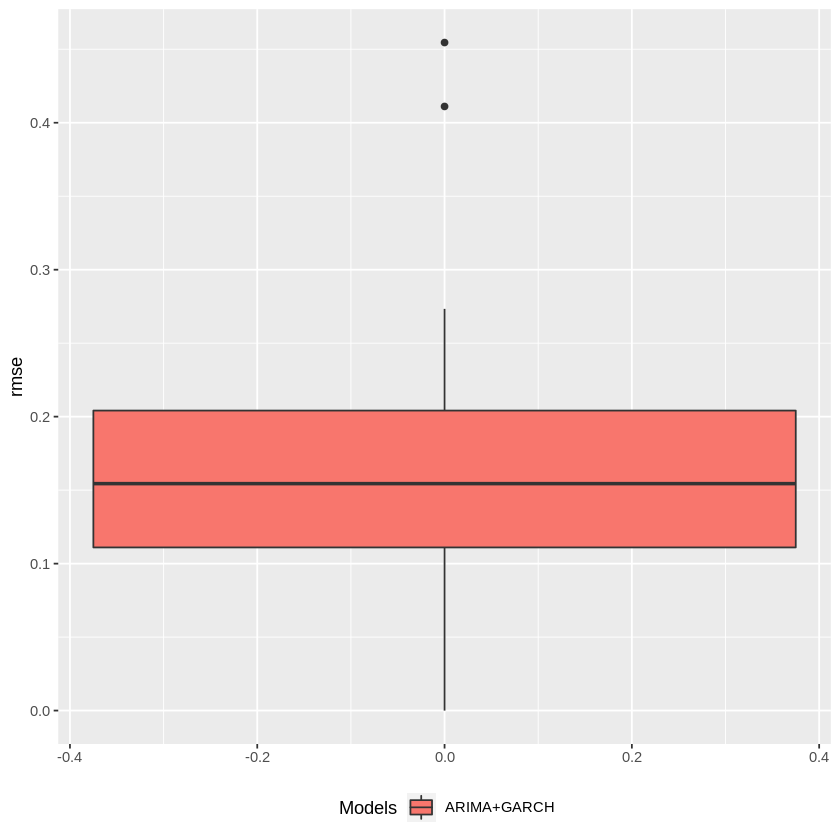

In [39]:
m <- n.get_result(results, 'ARIMA+GARCH')
n.plot_errors(m, metrics=c('rmse'))

# Gradient Boosting

# Model Comparision